<a href="https://colab.research.google.com/github/LukasBeckers/Transformer_Image_Completion/blob/main/Transformer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
# Imports

from google.colab.patches import cv2_imshow
from tensorflow.keras import layers
from glob import glob, escape
from keras.layers import activation
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle as pk
import numpy as np
import shutil
import random
import time
import cv2
import os

print(tf.__version__)

2.9.2


In [65]:
# Checking if a GPU is available on the system.

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1823252354661332145
xla_global_id: -1
]


In [66]:
# Connecting the notebook to your google-drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
"""
The ziped dataset is loaded from the google drive to the colab drive.
The dataset is copied from:/content/drive/MyDrive/Colab Notebooks/Transformer_Image_Completion
to /content 
"""
dataset_name = 'imagenet_r'
if not os.path.exists(f'/content/{dataset_name}.zip'):
    shutil.copy(f"/content/drive/MyDrive/Colab Notebooks/Transformer_Image_Completion/{dataset_name}.zip", 
                f"/content/{dataset_name}.zip")


In [68]:
"""
Unziping the directory.
"""
if  not os.path.isdir(f'/content/{dataset_name}'):
    shutil.unpack_archive(f"/content/{dataset_name}.zip", f"/content/{dataset_name}", 'zip')

In [69]:
"""
First all file-paths are loaded and stored into a list.
This is done by the 'load_data' function.
"""

def load_data(folder):
  """
  This function returns all jpeg-files that are in the path, 
  which is given as 'folder' parameter.
  
  :param folder:  str: Path to the folder, 
                       in which the jpeg-images of the dataset are stored.
                       
  :return:       list: List with paths to all the jpeg-files of the folder. 
                       The paths are returned as strings."""

  files = glob(f'{folder}/*.jpeg')
  return files

folder = f'/content/{dataset_name}'
files = load_data(folder)

print(f'Example file: {files[0]}')
print(f'Number of jpeg-files: {len(files)}')


Example file: /content/imagenet_r/1567_309.jpeg
Number of jpeg-files: 30000


In [70]:
# Splitting into test and train samples.

n_test = 5000
test_files, train_files = files[:n_test], files[n_test:]

print(f'Number of train-files: {len(train_files)}\nNumber of test-files: {len(test_files)}')

Number of train-files: 25000
Number of test-files: 5000


In [71]:
def read_image(image_path):
    '''
    This function takes a path to an image as argument and returns the image as 
    numpy array.

    :param image_path: string: Path to the image-file

    :return:           numpy array: Image loaded as numpy array.
    '''
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    return image.astype(np.float32)


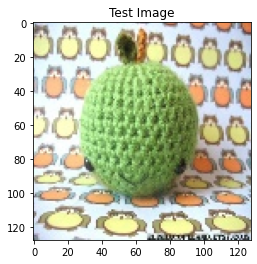

In [72]:
# Testing and Debugging

# Loading the image.
test_image = read_image(train_files[0])

# Plotting the image.
plt.imshow(test_image/255)
plt.title('Test Image')
plt.show()

In [73]:
"""
For this project I decided to use a self-coded transformer model. 

A transformer network transforms each element of a sequence individually.
A realation between the tokens is created in a transformer network via Multihead-self-attention.
For this reason each image must be converted to a sequence of vectors. 
This is done by splitting the images into smaller segments.
"""

def split_image(image, segment_width):
    '''
    This function crops the image, so that the width and the hight of the image 
    are devisible by the 'segment_width' parameter. 
    The cropped image is split into square-segments in the size of the 'segment_width'.

    :param image:           RGB-image (tf-tensor or np.array) of shape[higth, width, RGB]
    :param segment_width:   Width of the segments-squares that the image will be split into

    :return:                tf-tensor of shape[hight//segment_width, width//segment_width, segment_width, segment_width, RGB].
                            If the image width or hight is not devisable by the segment_width, it will be cropped.
    '''
    # Cropping the image
    image = image[:image.shape[0] // segment_width * segment_width]   # Cropping height
    image = image[:,:image.shape[1] // segment_width * segment_width] # Cropping width
    # Splitting the image.
    # First the width is split, then the hight of the image is split.
    image = tf.reshape(image, [image.shape[0],                        # height
                               image.shape[1]//segment_width,         # N_width_segments
                               segment_width,                         # segment_width
                               image.shape[2]                         # RGB
                               ])
    image = tf.transpose(image, [1, 0, 2, 3])                         # Swapping height and N_width_segments
    image = tf.reshape(image, [image.shape[0],                        # N_width_segments
                               image.shape[1]//segment_width,         # N_height_segments
                               segment_width,                         # segment_width
                               segment_width,                         # segment_width
                               image.shape[3]                         # RGB
                               ])
    image = tf.transpose(image, [1, 0, 2, 3, 4])                      # Swapping N_width_segments and N_height_segments
    # Output shape: [N_height_segments, N_width_segments, segment_width, segment_width, RGB]
    return image

"""
The output of the transformer-model will also have the shape of a split-image.
For this reason, a function to reverse the split process is needed.
This function will be able to create normal (non-split) images from split-images.
"""

def unsplit_image(image):
    '''
    This function reverses the split_image function (except the cropping).

    :param image:           split RGB-image tf-tensor of shape[N_height_segments, N_width_segments, segment_width, segment_width, RGB]

    :return:                RGB-image-batch tf-tensor of shape[N_images, heigth, width, RGB]
    '''
    image = tf.transpose(image, [1, 0, 2, 3, 4])                      # Swapping N_width_segments and N_height_segments
    image = tf.reshape(image, [image.shape[0],                        # N_width_segments
                               image.shape[1]*image.shape[2],         # N_hight_segments * segment_width = height
                               image.shape[3],                        # segment_width
                               image.shape[4]                         # RGB
                               ])
    image = tf.transpose(image, [1, 0, 2, 3])                         # Swapping height and N_width_segments
    image = tf.reshape(image, [image.shape[0],                        # height
                               image.shape[1]*image.shape[2],         # N_width_segments * segment_width = width
                               image.shape[3]                         # RGB
                               ])
    return image

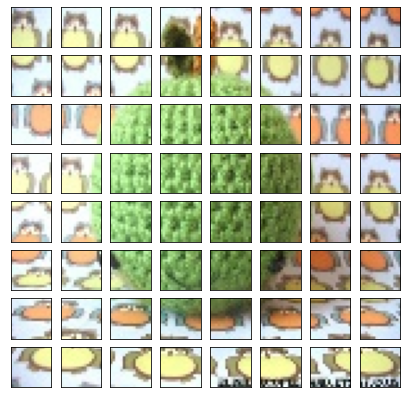

In [74]:
# Testing and Debugging

# Splitting the image.

segment_width = 16
split_test_image = split_image(test_image, segment_width)

# Plotting the split-test-image.
ig, axs = plt.subplots(test_image.shape[0]//segment_width,
                           test_image.shape[1]//segment_width,
                           figsize=[7, 7])

for i_row_g, row_g  in enumerate(axs):
    for i_col_g, col_g in enumerate(row_g):
        col_g.imshow(split_test_image[i_row_g, i_col_g]/255)

        # Removing the numbers on the axis.
        col_g.set_xticks([])
        col_g.set_yticks([])


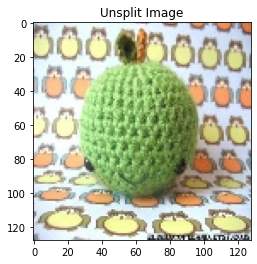

In [75]:
# Testing and Debugging

# Unsplitting the test image.
unsplit_test_image = unsplit_image(split_test_image)

# Plotting the unsplit test image.
plt.imshow(unsplit_test_image/255)
plt.title('Unsplit Image')
plt.show()

In [76]:
"""
For the training-process, a version of the split image function is needed,
that can split batches of images.
"""
def split_image_batch(batch, segment_width):
    """
    A version of the split_image function that can be applied to batches of images.

    :param batch:   tf.tensor: Batch of images, shape=[batch_size, hight, widht, RGB]
    :param segment_width: int: Width of the segments-squares that the image will be split into.

    :return:        tf-tensor: Batch of split images, shape = [batch_size, 
                                                               hight//segment_width, 
                                                               width//segment_width, 
                                                               segment_width,
                                                               segment_width,
                                                               RGB].
                               If the image width or hight is not devisable by the segment_width, it will be cropped.
    """
 
    # Cropping the images.
    batch = batch[:,:batch.shape[1] // segment_width * segment_width]   # Cropping height
    batch = batch[:,:,:batch.shape[2] // segment_width * segment_width] # Cropping width
    # Splitting the images.
    # First the width is split, then the hight of the image is split.
    batch = tf.reshape(batch, [batch.shape[0],                          # batch-size
                               batch.shape[1],                          # height
                               batch.shape[2]//segment_width,           # N_width_segments
                               segment_width,                           # segment_width
                               batch.shape[3]                           # RGB
                               ])
    batch = tf.transpose(batch, [0, 2, 1, 3, 4])                        # Swapping height and N_width_segments
    batch = tf.reshape(batch, [batch.shape[0],                          # batch-size
                               batch.shape[1],                          # N_width_segments
                               batch.shape[2]//segment_width,           # N_height_segments
                               segment_width,                           # segment_width
                               segment_width,                           # segment_width
                               batch.shape[4]                           # RGB
                               ])
    batch = tf.transpose(batch, [0, 2, 1, 3, 4, 5])                     # Swapping N_width_segments and N_height_segments
    # Output shape: [batch_size, N_height_segments, N_width_segments, segment_width, segment_width, RGB]
    return batch


def unsplit_batch(batch):
    '''
    This reverses the 'split_image_batch' function, excep for the cropping.
    It will be used to unsplit the output of the model.
    :param batch:           split-images batch tf-tensor of shape[N_images,
                                                                  N_hight_segments,
                                                                  N_width_segments,
                                                                  segment_width,
                                                                  segment_width, 
                                                                  RGB]
    :return:                RGB-image batch tf-tensor of shape[N_images, hight, width, RGB]
    '''
    batch = tf.transpose(batch, [0, 2, 1, 3, 4, 5])                           # Swapping N_width_segments and N_hight_segments
    batch = tf.reshape(batch, [-1,                                         # N_images
                               tf.shape(batch)[1],                         # N_width_segments
                               tf.shape(batch)[2]*tf.shape(batch)[3],      # N_hight_segments * segment_width = hight
                               tf.shape(batch)[4],                         # segment_width
                               3])  	                                   # RGB
    batch = tf.transpose(batch, [0, 2, 1, 3, 4])                              # Swapping height and N_width_segments
    batch = tf.reshape(batch, [-1,                                         # N_images
                               tf.shape(batch)[1],                         # hight
                               tf.shape(batch)[2]*tf.shape(batch)[3],      # N_width_segments * segment_width = width
                               3])
    return batch

In [77]:
def flatten_batch(batch):
    '''
    This function can be used inside the call-method of a keras model.
    This function will be used to flatten the image-batches for the transformer-layers in the model.
    :param images: (tf.tensor): Batch of split-images.
                                Shape for batch of images: [batch_size, n_hight_segments, n_width_segments, segment_width, segment_width, RGB]

    :return:       (tf.tensor): flattend batch of images.
                                Shape: [batch_size, n_hight_segments * n_width_segments, ?]
    '''
    out = tf.reshape(batch, [-1, tf.shape(batch)[1]*tf.shape(batch)[2], tf.shape(batch)[3]*tf.shape(batch)[4]*tf.shape(batch)[5]])
    return out

def unflatten_batch(images, n_hight_segments, n_width_segments, segment_width):
    '''
    This function can be used inside the call-method of a keras model.
    This function reverses the flatten operation done to a batch of images by the 'flatten_batch' function
    :param images: (tf.tensor): Batch of flattend RGB-images.
                                Shape: [batch_size, n_hight_segments * n_width_segments, ?]

    :return:       (tf.tensor): Batch of split RGB-images.
                                Shape: [batch_size, n_hight_segments, n_width_segments, segment_width, segment_width, RGB]
    '''
    out = tf.reshape(images, [-1, n_hight_segments, n_width_segments, segment_width, segment_width, 3])
    return out

In [78]:
def preprocess(image):
    '''
    :param image:           string. Path to the image-file
    :return:                tf tensors. Image as tf-tensor. Scaled between 0 and 1.
    '''
    def load(image):
        image = image.decode()      # Cleaning up the format.
        image = read_image(image)   
        image /= 255                # Scaling the image between 0 and 1.
        return image
    image = tf.numpy_function(load, [image], tf.float32)   # Expected output -- tf tensor with dtype=tf.float32
    return image


def tf_dataset(images, batch_size=100, segment_width=16):
    '''
    :param images:                  (list of strings): List of paths to the image files.
    :param batch_size:              (int): Number of samples per batch.
    :param segment_width:           (int): Segment-width by which the images will be split by the split_image function.

    :return:                        (tfds): 
    '''
    def split_image_wrapper(image):
        image = tf.numpy_function(split_image_batch, [image, segment_width], tf.float32)
        return image

    def remove_last_element(batch):
        """
        The model will be trained to predict the next image segment of the image
        autoregressively. For this reason the last element of the split- and  
        flattend-images is removed. 
        In the call function of the model, a start token will be added to the 
        start of the image-sequence. This way, the input and target sequence are 
        shifted for on image-segment to each other.
        """
        inputs = batch[:,:-1]
        targets = batch
        return inputs, targets

    dataset = dataset = tf.data.Dataset.from_tensor_slices((images))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess)
    dataset = dataset.padded_batch(batch_size, padded_shapes=[None, None, None])
    dataset = dataset.map(split_image_wrapper)
    dataset = dataset.map(flatten_batch)
    dataset = dataset.map(remove_last_element)
    dataset = dataset.prefetch(1)
    return dataset



In [79]:
# Here the datasets are defined.

# Creating the train- and test-dataset.
batch_size = 500
train_ds = tf_dataset(train_files, batch_size=batch_size, segment_width=segment_width)
test_ds = tf_dataset(test_files, batch_size=batch_size, segment_width=segment_width)

for test_batch in train_ds:
    break

print(f'Images with positions batch shape: {test_batch[0].shape}, original images batch shape: {test_batch[1].shape}')

Images with positions batch shape: (500, 63, 768), original images batch shape: (500, 64, 768)


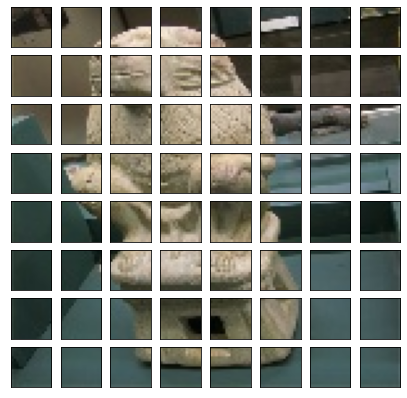

In [80]:
# Testing and Debugging

# Unflatten the test_batch.
unfl_batch = unflatten_batch(test_batch[1], 8, 8, 16)

# Scaling the image between 0 and 1.
test_image = unfl_batch[0]
test_image -= tf.math.reduce_min(test_image)
test_image /= tf.math.reduce_max(test_image)

# Plotting the split-test-image.
fig, axs = plt.subplots(test_image.shape[0],
                           test_image.shape[1],
                           figsize=[7, 7])

for i_row_g, row_g  in enumerate(axs):
    for i_col_g, col_g in enumerate(row_g):
        col_g.imshow(test_image[i_row_g, i_col_g])

        # Removing the numbers on the axis.
        col_g.set_xticks([])
        col_g.set_yticks([])
plt.show()

In [81]:
"""
The envisioned transformer-model will be a decoder only model, which will be 
trained autoregressively. 
For this reason a forward facing attention mask will be created in the 
MultiHeadSelfAttention foreward call. 
This mask will prevent the transformer-model from attending to image-semgents 
further forward in the sequence.
"""


class MultiHeadSelfAttention(tf.keras.Model):
    def __init__(self, model_dim, n_heads, dropout_rate=0.1):
        '''
        :param model_dim:       (int): Model dimension.
        :param n_heads:         (int): Number of attention heads
        :param dropout_rate:    (int): dropout_rate used in the Multiheaded attention layer
        '''
        super(MultiHeadSelfAttention, self).__init__()
        assert model_dim % n_heads == 0, f'The dimension of the model must be devisible by the number of used attention heads.\nargs:\n\tnumber of heads: {n_heads}\n\tmodel dimension: {model_dim}\nrest:\t´{model_dim%n_heads}'

        self.model_dim = model_dim
        self.n_heads = n_heads
        # Calculating the head dimension
        self.head_dim = int(model_dim/n_heads)
        # Creating a key, query and value layer for all attention heads
        self.key_layer = layers.Dense(self.head_dim, use_bias=False)
        self.query_layer = layers.Dense(self.head_dim, use_bias=False)
        self.value_layer = layers.Dense(self.head_dim, use_bias=False)
        # Creating a dropout-layer for the linear layers
        self.dropout = layers.Dropout(dropout_rate)
        # Softmax function for the attention matrix
        self.softmax = activation.Softmax(axis=3)

    def call(self, inputs):
        '''
        :param inputs: (tf.tensor): Input Tensor of shape [Batch_size, n_segments, model_dim]
                                    If the multi-head attention object is part of the first transformer layer,
                                    the input is the split and flattended batch of  images with both the width and
                                    hight embeddings allready added.

        :return:       (tf.tensor). Output of the multi-head attention object. Shape [Batch_size, n_segments, model_dim]
        '''
        def create_mask(n_segments):
            """
            This function creates a boolean mask for the attention-matrix.
            This mask will be a simple mask which prevents forward attention.

            Example for n_segments=4:

            [[[[True], [False], [False], [False]],    
              [[True], [True],  [False], [False]],
              [[True], [True],  [True],  [False]],
              [[True], [True],  [True],  [True]]
            ]]

            :param n_segments: (int): Number of image-segments of the input of the 
                               'call'-function.

            :return:           (tf-tensor, dtype=bool): Attention maks of shape:[1, 1, n_segments, n_segments]
            """
            mask = tf.linalg.band_part(tf.ones((1, 1, n_segments, n_segments), tf.bool), -1, 0)
            return mask

        # splitting the inputs into the correct number of n_heads_g
        # Reshaping to [Batch_size, n_segments, n_heads, head_dimensions]
        inputs = tf.reshape(inputs, [-1, tf.shape(inputs)[1], self.n_heads, self.head_dim])
        keys = self.key_layer(self.dropout(inputs))
        queries = self.query_layer(self.dropout(inputs))
        values = self.value_layer(self.dropout(inputs))
        # computing the attention-matrix
        # Einsum Function: 'keys'[Batch_size, n_segments, n_heads, head_dimensions],
        # 'queries'[Batch_size, n_segments, n_heads, head_dimensions] -> 'attention_-matrix'[Batch_size, n_heads,
        # n_segments_queries, n_segments_keys]
        attention_matrix = tf.einsum('nqhd, nkhd->nhqk', queries, keys)
        # Scaling the attention matrix by the square-root of the model-dimension.
        attention_matrix /= self.head_dim**0.5
        # Creating the attention-mask.
        attention_mask = create_mask(tf.shape(inputs)[1])
        # Applying the softmax function to the attention matrix.
        attention_matrix = self.softmax(attention_matrix, attention_mask)
        # Using the scaled attention_matrix and applying it to the value tensor.
        # Einsum Function: 'attention_matrix'[Batch_size, n_heads, n_segments_queries, n_segments_keys],
        # 'values'[Batch_size, n_segments_values, n_heads, head_dimensions] -> 'output'[Batch_size, n_segments,
        # n_heads, head_dimensions]
        output = tf.einsum('nhql, nlhd->nqhd', attention_matrix, values)
        #reshaping the output to [Batch_size, n_segments, model_dimensions]
        output = tf.reshape(output, [-1, tf.shape(output)[1], self.model_dim])
        return output



In [82]:
# Testing and Debugging.

# Creating the multiheadselfattention object.
n_heads = 2
model_dimension = 256
multiheadselfattention = MultiHeadSelfAttention(model_dimension, n_heads)

# Loading the input-images.
test_images = test_batch[0]

# Testing the model.
out = multiheadselfattention(test_images)
multiheadselfattention.summary()
print(f'Mean value of the output = {tf.reduce_mean(out)}')


Model: "multi_head_self_attention_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            multiple                  16384     
                                                                 
 dense_51 (Dense)            multiple                  16384     
                                                                 
 dense_52 (Dense)            multiple                  16384     
                                                                 
 dropout_18 (Dropout)        multiple                  0         
                                                                 
 softmax_10 (Softmax)        multiple                  0         
                                                                 
Total params: 49,152
Trainable params: 49,152
Non-trainable params: 0
_________________________________________________________________
Mean value of the output = -0.0336

In [83]:
# Using the MultiHeadAttention class, a transformer-layer class with linear expansion is created.

class TransformerLayer(tf.keras.Model):
    def __init__(self, model_dim, n_heads, linear_expansion, dropout_rate=0.1):
        '''
        :param model_dim:        (int): Dimensions of the model.
        :param n_heads:          (int): Number of attention heads
        :param linear_expansion: (int): During linear expansion, the output will be expanded to
                                        linerar_expansion * model_dim
        :param dropout_rate:     (int): dropout_rate used in the transformer-layer
        '''
        super(TransformerLayer, self).__init__()
        self.model_dim = model_dim
        self.n_heads = n_heads
        self.linear_expansion = linear_expansion
        self.dropout_rate = dropout_rate
        # defining the layers
        self.multi_head_attention = MultiHeadSelfAttention(model_dim = self.model_dim,
                                                           n_heads = self.n_heads,
                                                           dropout_rate=self.dropout_rate)
        self.input_layer = layers.InputLayer(input_shape=(self.model_dim, ))
        self.layer_1 = layers.Dense(self.model_dim*self.linear_expansion, activation='relu')
        self.layer_2 = layers.Dense(self.model_dim, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.norm1 = layers.BatchNormalization()
        self.norm2 = layers.BatchNormalization()

    def call(self, inputs):
        '''
        :param inputs: (tf.tensor): Input Tensor of shape [Batch_size, n_segments, model_dim]
                                    If the multi-head attention object is part of the first transformer layer,
                                    the input is the split and flattended batch of  images with both the width and
                                    hight embeddings allready added.
        :return:       (tf.tensor). Output of the transformer-layer. Shape [Batch_size, n_segments, model_dim]
        '''
        skip_0 = inputs
        out = self.multi_head_attention(inputs)
        # Skip connection to counteract deminishing gradients
        out = self.norm1(out + skip_0)
        skip_1 = out
        out = self.layer_1(self.dropout(out))
        out = self.layer_2(self.dropout(out))
        # Skip connection to counteract deminishing gradients
        out = self.norm2(out + skip_1)
        return out

In [84]:
# Testing and Debugging.

# Creating a transformerlayer object.
n_heads = 4
model_dimension = test_batch[0].shape[-1] # = 768
linear_expansion = 4
transformerlayer = TransformerLayer(model_dimension, n_heads, linear_expansion)

# Loading the input-images.
test_images = test_batch[0]

# Testing the model.
out = transformerlayer(test_images)
transformerlayer.summary()
print(f'Mean value of the output = {tf.reduce_mean(out)}')

Model: "transformer_layer_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_head_self_attention_1  multiple                 110592    
 1 (MultiHeadSelfAttention)                                      
                                                                 
 input_9 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_56 (Dense)            multiple                  2362368   
                                                                 
 dense_57 (Dense)            multiple                  2360064   
                                                                 
 dropout_20 (Dropout)        multiple                  0         
                                                                 
 batch_normalization_20 (Bat  multiple                 3072      
 chNormalization)                              

In [85]:
"""
The envisioned transformer model will transform each segment of the image individually.
The model will then attend between the transformed tokens via multiheadattention.
All these steps are not influenced by the order of the image segments in the sequence.
This is unwanted for processing an image, because the order 
of the image-segments obviously matters a lot in a picture.
For this reason to each image-semgent a vector is added, 
which encodes the position of this semgent in the context of the whole image.

Positional Encoding as described in the paper "Attention is all you need"
Doi: arXiv:1706.03762v5 [cs.CL] 6 Dec 2017
"""

class PositionalEncoding():
    '''
    Creates an PositionalEncoding object, with defined maximum sequence length and encoding dimension.
    '''
    def __init__(self, max_length, encoding_dimension):
        '''
        :param max_length:           Maximum position that can be meening-fully encoded.

        :param encoding_dimension:   Dimension of the encoded positions.
                                     This parameter should match the encoding dimension of the transformer model, that is used.
        '''
        self.max_length = max_length                    # Highest encoded position.
        self.encoding_dimension = encoding_dimension    # Output dimension of the positional encoding vector

    def __call__(self, positions):
        '''
        :param positions: An array of positions to encode.
                          All positions should be in form of ints.
                          Example: positions=[0, 1, 3] would return a tensor of shape [3, encoding_dimension]
                          with the encoded positions 0, 1, 3.
        :return:          Tensorflow Tensor of shape [N_positons, encoding_dimension]
        '''
        encoded_positions = np.full([len(positions), self.encoding_dimension],  # 2D np.array of shape [N_positions, encoding_dimensions]
                                    tf.range(self.encoding_dimension),          # filled with numbers from 0...(encoding_dimension-1)
                                    dtype=np.float32)
        encoded_positions = encoded_positions//2                                # all elements of array floor-devided by two
        encoded_positions = self.max_length**(-2
                                              *encoded_positions
                                              /self.encoding_dimension)
        positions_array = np.full([self.encoding_dimension,
                                   len(positions)],
                                  positions)

        positions_array = np.swapaxes(positions_array, 0, 1)
        encoded_positions = encoded_positions * positions_array
        encoded_positions[::2] += np.pi/2                                       # Adding Pi/2 to every odd row, so that sin = cos for odd rows.
        encoded_positions = np.sin(encoded_positions)                           # Calling the sinus function on each element in the array.
        encoded_positions = tf.convert_to_tensor(encoded_positions,             # Converting output to tensorflow tensor.
                                                 dtype=tf.float32)
        return encoded_positions

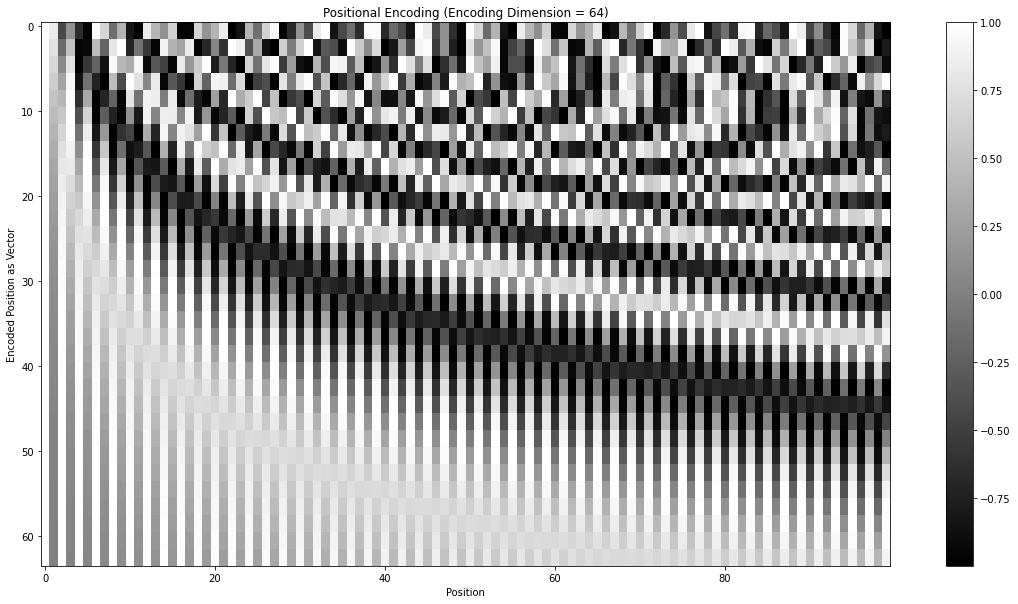

In [97]:
# Testing and Debugging
# Shows the encoded-vectors for 100 successive positions (max_length = 100, encoding_dimension = 64)

max_length = 100
encoding_dimension = 64
n_positions = 100

# Generating the encodings.
test_positional_encoder = PositionalEncoding(max_length, encoding_dimension)
encoded_positions = test_positional_encoder([i for i in range(n_positions)])
image_encoded_positions = tf.transpose(encoded_positions, [1, 0])

# Plotting the Encodings.
fig, axs = plt.subplots(1, figsize=[20, 10])
im = axs.imshow(image_encoded_positions, cmap='gray')
axs.set_xlabel('Position')
axs.set_ylabel('Encoded Position as Vector')
axs.set_title(f'Positional Encoding (Encoding Dimension = {encoding_dimension})')
plt.colorbar(im)
plt.show()

In [98]:
"""
The 'TransformerLayer' class is used to create the final model.
"""

class TransformerModel(tf.keras.Model):
    def __init__(self, model_dim, image_dim, n_heads, linear_expansion, n_layers, dropout_rate=0.1, max_length=100):
        '''
        :param model_dim:        (int): Dimensions of the model.
        :param image_dim:        (int): Number of pixels per image-segment.
        :param linear_expansion: (int): During linear expansion in the transformer-layers,
                                        the output will be expanded to linerar_expansion * model_dim
        :param n_heads:          (int): Number of attention heads
        :param n_layers:         (int): Number of layers the model will be comprised of.
        :param dropout_rate:     (int): dropout_rate used in the transformer-layer
        '''
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim
        self.image_dim = image_dim
        self.n_heads = n_heads
        self.linear_expansion = linear_expansion
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        self.max_length=max_length

        # creating the positional encoder.
        self.pos_enc = PositionalEncoding(self.max_length, self.model_dim)

        self.norm1 = layers.BatchNormalization()
        # Defining the layers
        self.image_encoding = layers.Dense(self.model_dim)
        self.transformer_layers = []
        for _ in range(self.n_layers):
            self.transformer_layers.append(TransformerLayer(self.model_dim,
                                                self.n_heads,
                                                self.linear_expansion,
                                                self.dropout_rate))

        self.norm_out = layers.BatchNormalization()
        # The output of the model should be a RGB-image of the same size as the input.
        self.output_layer = layers.Dense(self.image_dim, activation='sigmoid')
        # Defining a learnable 'start_sequence_token' 
        self.start_sequence_token = tf.random.uniform([1, 1, self.model_dim])
        

    def call(self, inputs):
        '''
        :param inputs:  (tf.tensor): Batch of images
        :return:       (tf.tensor): Batch of predicted segmentation masks. Shape=[batch_size, N_segments_hight, N_segments_width]
        '''
        def add_start_token(inputs):
            """
            This function adds the learnable 'start_sequence_token' to the start 
            of the image-segment seqences.           
            :param inputs:  (tf.tensor): Input of the 'call'-function, flattened
                                         by the 'flatten_batch' function.
                                         shape=[batch_size, n_segments, N_pixels_per_segment]
                                         
            """
            batch_size = inputs.shape[0]
            start_sequence_token = tf.concat([self.start_sequence_token for _ in range(batch_size)], axis=0)
            inputs = tf.concat([start_sequence_token, inputs], axis=1)
            return inputs

        def add_positions(inputs, strength=0.4):
            """
            This function encodes the positions of the image segments, after the 
            'flatten_batch' function.
            :param inputs:   (tf.tensor): Inputs of the call function after flatten batch and image encoding call.
            :param strength: (float): Factor by which the positional encodings are scaled before they are added to the image
            """
            batch_size = inputs.shape[0]
            positions = self.positional_encoding([i for i in range(inputs.shape[1])])
            positions = tf.stack([positions for _ in range(batch_size)])
            positions *= strength
            return inputs + positions

        skip_1 = self.image_encoding(inputs)
        n_segments = tf.shape(skip_1)[1]
        inputs = tf.numpy_function(add_start_token, [skip_1], tf.float32)
        # Now the 'inputs' tensor is reshaped to the expected shape.
        # Note: This step does not change the shape of the tensor, it is only 
        # done so that the tensorflow autograph-function knows the shape of 'inputs' after
        # the numpy-function-call.
        inputs = tf.reshape(inputs, [-1, n_segments+1, self.model_dim])  # n_segments + 1 due to the added start-token

        # Adding skip-connection to allow a gradient flow arround the numpy-functions.
        slice_1 = inputs[:,1:] 
        slice_2 = inputs[:,:1]
        slice_1 += skip_1
        inputs = tf.concat([slice_2, slice_1], axis=1)
        inputs = self.norm1(inputs)

        for layer in self.transformer_layers:
           inputs = layer(inputs)

        inputs = self.norm_out(inputs)
        inputs = self.output_layer(inputs)
        output = inputs
        return output


In [99]:
# Here the model is defined.
model_dimension = 1000
image_dim = segment_width**2*3
n_heads = 8
linear_expansion = 4
n_layers = 3
dropout_rate = 0.1
max_length = 100

model = TransformerModel(model_dimension,
                         image_dim,
                           n_heads,
                           linear_expansion,
                           n_layers,
                           dropout_rate, 
                           max_length)

In [100]:
# Testing and Debugging

out = model.predict(test_images)
model.summary()
print(f'Mean value of the output = {tf.reduce_mean(out)}')

16/16 [==============================] - 37s 2s/step
Model: "transformer_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_30 (Bat  multiple                 4000      
 chNormalization)                                                
                                                                 
 dense_75 (Dense)            multiple                  769000    
                                                                 
 transformer_layer_12 (Trans  multiple                 8059875   
 formerLayer)                                                    
                                                                 
 transformer_layer_13 (Trans  multiple                 8059875   
 formerLayer)                                                    
                                                                 
 transformer_layer_14 (Trans  multiple                 80598

In [101]:
# Defining the loss-function.
loss_function = tf.keras.losses.MeanSquaredError()

In [102]:
print(f'Loss without training: {loss_function(test_batch[1], out)}')

Loss without training: 0.26580584049224854


In [103]:
# Compiling the model.
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), loss=loss_function)

In [104]:
# Creating a custom callback, that is called after every epoch.
# This callback saves the model's weights if a new best val_loss is found.

model_path = "/content/drive/MyDrive/Colab Notebooks/Transformer_Image_Completion/model_checkpoints/Weights"

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model_path):
        self.model_path = model_path
        self.min_loss = 10**100

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.min_loss:
            self.min_loss = val_loss
            model.save_weights(self.model_path)


        


my_callback = CustomCallback(model_path)

In [105]:
# Loading the model, if the training was done in part in a previous session.
try:
    model.load_weights(model_path)
    print('Loaded model from checkpoint')
except Exception: pass

Loaded model from checkpoint


In [ ]:
# Training the model
model.fit(train_ds, validation_data=test_ds, epochs=100, callbacks=[my_callback])

Epoch 1/100


In [ ]:
# Printing the model's predictions.

for test_batch in test_ds:
    break

out = model.predict(test_batch[0])
#out -= tf.math.reduce_min(out)
#out /= tf.math.reduce_max(out)
out = unflatten_batch(out, 8, 8, 16)
unsplit_out = unsplit_batch(out)
targ = unflatten_batch(test_batch[1], 8, 8, 16)
unsplit_targ = unsplit_batch(targ)

n = 50
fig, axs = plt.subplots(n, 2, figsize=[10, 10*n])
for i in range(n):
    axs[i, 0].imshow(unsplit_out[i])
    axs[i, 1].imshow(unsplit_targ[i])
plt.show()